# Exercise 1: a first look at seismic data

In this exercise we will load some data into Julia and perform some basic operations.

Seismic data are typically stored in a special binary format: SEGY. These file-formats store the data as mutliple time-series (traces) with the corresponding header information containing specific information about such as time sampling and source/receiver locations.

The Julia utilities for reading  SEGY data is SegyIO


In [1]:
using Pkg
#Pkg.add(url="https://github.com/slimgroup/SegyIO.jl.git")
#Pkg.add("PyPlot")
using SegyIO, PyPlot

# Scaning the dataset

Thhe first step is to scan the dataset to extract header/metadat. This metadat contains the geometry and parameters of the survey such as the source/receiver locations and time sampling rate. The convention for the metadata is as follows:

    The Source positions use the Source keyword such as SourceX
    The receiver position use the Group keyword such as GroupX



In [2]:
# scan the dataset

dir = Pkg.dir("SegyIO")
data_dir = "data"

┌ Warning: `Pkg.dir(pkgname, paths...)` is deprecated; instead, do `import SegyIO; joinpath(dirname(pathof(SegyIO)), "..", paths...)`.
└ @ Pkg.API /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Pkg/src/API.jl:415


"data"

We can now scans the dataset with the segy_scan functin. This function returns a SeisCOn object where each block is a shot record with its metadata.

In [3]:
blocks = segy_scan(string(dir, data_dir), "overthrust", ["GroupX", "GroupY", "ns", "dt"]);

Scanning ... /home/yzhang3198/.julia/packages/SegyIO/ak2qG/data/overthrust_2D_shot_41_60.segy
Scanning ... /home/yzhang3198/.julia/packages/SegyIO/ak2qG/data/overthrust_2D_shot_21_40.segy
Scanning ... /home/yzhang3198/.julia/packages/SegyIO/ak2qG/data/overthrust_2D_shot_61_80.segy
Scanning ... /home/yzhang3198/.julia/packages/SegyIO/ak2qG/data/overthrust_2D_shot_1_20.segy
Scanning ... /home/yzhang3198/.julia/packages/SegyIO/ak2qG/data/overthrust_2D_shot_81_97.segy


Now extract the time, source and receiver coordinates (in seconds and meters) for all the traces. The source and receiver vectors have a length equal to the number of traces, the time vector has a length equal to the number of rows in the data matrix.

In [4]:
sx = [get_header(blocks[i], "SourceX") for i=1:length(blocks)];
rx = [get_header(blocks[i], "GroupX") for i=1:length(blocks)];

In [5]:
# Get the tme axis. In this case the time axis is the same for all traces so we only need to extract it from the first trace
# dt needs to be corrected for the binary setup
# All the times are in ms
dt = get_header(blocks[1], "dt")[1]/1000
nt = get_header(blocks[1], "ns")[1]
T = 0:dt:(nt-1)*dt

0.0:4.0:3000.0



Calculate the offset and midpoint for each trace. This gives you vectors m (midpoint) and h (offset) with length equal to the number of traces.

h = (s - r)/2;

m = (s + r)/2;


In [6]:
h = (sx .- rx)./2;
m = (sx .+ rx)./2;



The fold of the data is the number of traces in each midpoint gather. This can be easily visualized by a histogram. As we have a set of blocks we need to inspect each block seperately to recover the nuique set of midpoint location and the total number fo traces for this midpoint


In [7]:
all_m = hcat(m'...)
fold = [sum(all_m .== unique(all_m)[i]) for i=1:length(unique(all_m))];

all_h = hcat(h'...);

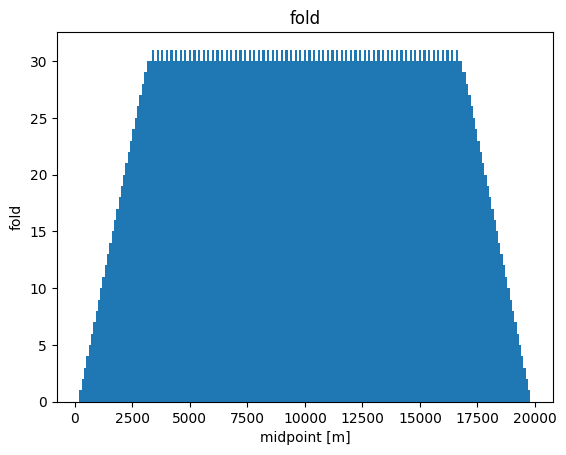

In [8]:
figure();
bar(unique(all_m),fold ,align="center", width=100);
xlabel("midpoint [m]");
ylabel("fold");
title("fold");



Can you interpret this figure?

Different gathers

Extract a midpoint gather. For example, a midpoint gather at m = 2550 looks like this:


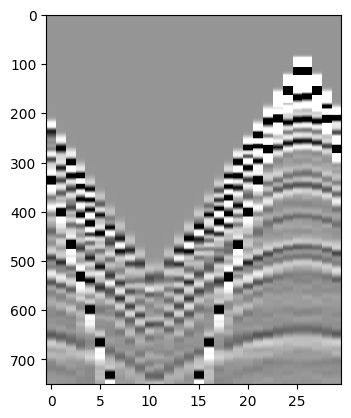

PyObject <matplotlib.image.AxesImage object at 0x7f49363d4e48>

In [9]:
Im = findall(all_m .== 7500.)
figure()
imshow(Float32.(blocks[1:97].data[:,map(i -> i[2], Im)]), vmin=-1, vmax=1, cmap="Greys", aspect=0.05)



Extract an offset-gather. For example, a zero-offset section looks like:


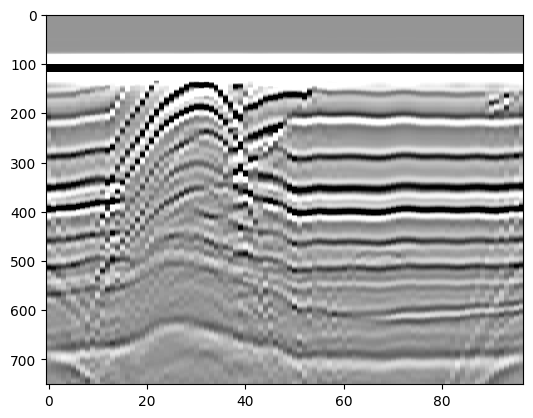

PyObject <matplotlib.image.AxesImage object at 0x7f4935b5f860>

In [10]:
Ih = findall(all_h .== 0.)
inds = sortperm(all_m[Ih])
figure()
imshow(Float32.(blocks[1:97].data[:,map(i -> i[2], Ih[inds])]), vmin=-1, vmax=1, cmap="Greys", aspect=.1)

What other different gathers can you think of? Extract and plot an example of all the different gathers. What are characteristic properties of the different gathers? Do not forget to label the axis and choose a reasonable colorscale. Hint: use cmap=Greys and adjust the color-axis vmin/vmax